In [1]:
import os
import pandas as pd
from emobpy import DataBase
from emobpy import Mobility, DataBase, Consumption, HeatInsulation, BEVspecs, Availability, Charging
import shutil

ModuleNotFoundError: No module named 'emobpy'

In [ ]:
home_path = os.getcwd()
os.makedirs(os.path.join(home_path, "db", "used"), exist_ok=True)
consumption_path = os.path.join(home_path, "db", "consumption")
availability_path = os.path.join(home_path, "db", "availability")
profile_path  = os.path.join(home_path, "db", "profile")

DB_profile = DataBase('db/profile')

#os.chdir("../")
data_path = os.getcwd()
data_path

In [7]:
number_profiles = 10
year = 2020

In [ ]:
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            #elif entry.is_dir():
             #   total += get_dir_size(entry.path)
    total = total / (10**9)
    return total

def create_new_folder(path, profile_consumption_availability = None, used_dir=False):
    if used_dir == False:
        folder_list = [d for d in os.listdir(path)
                   if os.path.isdir(os.path.join(path, d))]
    
        if len(folder_list) == 0:
            new_f = "0"   
        else:
            new_f = str(max(map(int,folder_list)) + 1)
        new_f_path = os.path.join(path, new_f)
        
    else: 
        new_f_path = os.path.join(home_path, "db", "used", profile_consumption_availability)
    
    os.makedirs(new_f_path, exist_ok=True)

    return new_f_path

def transtion_files(source_dir):
    target_dir = create_new_folder(source_dir)

    file_names = [f for f in os.listdir(source_dir)
                       if os.path.isfile(os.path.join(source_dir, f))]

    for file_name in file_names:
        shutil.move(os.path.join(source_dir, file_name), target_dir)
        
def get_folders(path): 
    f_list = [d for d in os.listdir(path)
              if os.path.isdir(os.path.join(path, d))]
    if ".DS_Store" in f_list:
        f_list.remove(".DS_Store")
    
    return f_list

## Step 1: Vehicle mobility time series

In [5]:
from emobpy import Mobility

def mobility_gen (i):
    m = Mobility(config_folder='config_files')
    m.set_params(
             name_prefix="BEV{}".format(i),
             total_hours=300, 
             time_step_in_hrs=0.25, # 15 minutes
             category="user_defined",
             reference_date=f"01/01/{year}"
            )
    m.set_stats(
            stat_ntrip_path="TripsPerDay.csv",
            stat_dest_path="DepartureDestinationTrip.csv",
            stat_km_duration_path="DistanceDurationTrip.csv",
            )
    m.set_rules(rule_key="user_defined") 
    # see /config_files/rules.yml, it contains a dictionary, whose key must be the same
    # as rule_key. To see all possible rules `from emobpy.constants import RULE; RULE` 
    m.run()
    m.save_profile(folder="db/profile", description='') # save all info in pickle file in 'db' folder



In [6]:
for i in range(number_profiles):
    
    if get_dir_size(profile_path) < 1:
        mobility_gen(i)
        
    else:
        create_new_folder(profile_path)
        transtion_files(profile_path)
        mobility_gen(i)
    
    DB_profile.update()                # This load new files hosted in database folder as result of new generated files

transtion_files(profile_path)

New profile running: BEV0_W2_2e694
Progress: 100% [12 / 12] days
Profile done: BEV0_W2_2e694
Elapsed time (min): 0.15
 
See Log files
/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage/Modelling/Git_hub/EES/Emobpy/my_emobpy/log/emobpy.log
New profile running: BEV1_W2_884e5
Progress: 100% [12 / 12] days
Profile done: BEV1_W2_884e5
Elapsed time (min): 0.01
 
See Log files
/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage/Modelling/Git_hub/EES/Emobpy/my_emobpy/log/emobpy.log
New profile running: BEV2_W2_55cf0
Progress: 100% [12 / 12] days
Profile done: BEV2_W2_55cf0
Elapsed time (min): 0.01
 
See Log files
/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage/Modelling/Git_hub/EES/Emobpy/my_emobpy/log/emobpy.log
New profile running: BEV3_W2_49099
Progress: 100% [12 / 12] days
Profile done: BEV3_W2_49099
Elapsed time (min): 0.02
 
See Log files
/Users/Jarusch/Do

In [43]:
#m.kind
#m.description
#m.timeseries
#m.profile.head()
#from emobpy.plot import NBplot
#fig_mobility = NBplot(DB_profile).sgplot_dp(m.name)
#fig_mobility

------------------------------------------------------
## Step 2: Driving consumption time series
------------------------------------------------------
a) Vehicle model configuration

------------------------------------------------------

In [8]:
from emobpy import Consumption, HeatInsulation, BEVspecs

In [9]:
HI = HeatInsulation(True)            # Creating the heat insulation by copying the default configuration
BEVS = BEVspecs()

models = {
    "Tesla": 
        {"model": "Model 3 Long Range AWD",
         "year": 2019,
         "share": 22.73},
    "Volkswagen":
        {"model": "ID.3",
         "year": 2020,
         "share": 15.91},
    "Renault":
        {"model": "Zoe Q90",
         "year": 2017,
         "share": 15.91},
    "Hyundai":
        {"model": "Kona Electric 64 kWh",
         "year": 2019,
         "share": 11.63},
    "FIAT":
        {"model": "500e",
         "year": 2019,
         "share": 9.09},
    "BMW":
        {"model": "i3 33 kWh",
         "year": 2017,
         "share": 6.82},
    "MINI":
        {"model": "Cooper SE Level I",
         "year": 2020,
         "share": 6.82},
    "Audi": 
        {"model": "e-tron 55 quattro",
         "year": 2019,
         "share": 4.55},
    "Hyundai": 
        {"model": "IONIQ Electric 28 kWh",
         "year": 2019,
         "share": 4.55},
    "KIA": 
        {"model": "e-Niro 64 kWh",
         "year": 2019,
         "share": 2.27}
    
}

back_up_model = {
    "brand": "Volkswagen",
    "model": "e-Golf SE",
    "year": 2019
}

In [10]:
p_list = os.listdir(profile_path)
if ".DS_Store" in p_list:
    p_list.remove(".DS_Store")
elif '.ipynb_checkpoints' in p_list:
    p_list.remove('.ipynb_checkpoints')
    
number_profiles_all = -1

for folder in p_list:
    number_profiles_all += len([d for d in os.listdir(os.path.join(profile_path, folder))
     if os.path.isfile(os.path.join(profile_path, folder, d))])
    
models_assigned = {}

i = 0
for brand in models.keys():
    models[brand]["number"] = round(number_profiles_all*models[brand]["share"]/100)
    #print(brand + " " +str(models[brand]["number"]))
    for k in range(0, round(models[brand]["number"])): 
        print(str(i))
        models_assigned[str(i)] = BEVS.model((
            brand, models[brand]["model"], models[brand]["year"]
        ))
        i += 1
        
while i <= number_profiles_all:
    
    models_assigned[str(i)] = BEVS.model((
            back_up_model["brand"], back_up_model["model"], back_up_model["year"]
        ))
    i += 1

0
Fallback value 0.9 added for missing battery_charging_eff parameter.
Fallback value 0.95 added for missing battery_discharging_eff parameter.
Fallback value 0.95 added for missing transmission_eff parameter.
Fallback value 0.3 added for missing auxiliary_power parameter.
Fallback value 3.5 added for missing cabin_volume parameter.
Fallback value 1 added for missing hvac_cop_heating parameter.
Fallback value 2 added for missing hvac_cop_cooling parameter.
1
Fallback value 0.9 added for missing battery_charging_eff parameter.
Fallback value 0.95 added for missing battery_discharging_eff parameter.
Fallback value 0.95 added for missing transmission_eff parameter.
Fallback value 0.3 added for missing auxiliary_power parameter.
Fallback value 3.5 added for missing cabin_volume parameter.
Fallback value 1 added for missing hvac_cop_heating parameter.
Fallback value 2 added for missing hvac_cop_cooling parameter.
2
Fallback value 0.9 added for missing battery_charging_eff parameter.
Fallbac

In [11]:
#plausibility check
len(models_assigned) - number_profiles_all

1

In [12]:
def consumption_gen(i, file, DB):
    car_model = models_assigned[str(i)]
    print(car_model.parameters['EV Model'])
    c = Consumption(file, car_model)
    c.load_setting_mobility(DB)
    c.run(
        heat_insulation=HI,
        weather_country='DE',
        weather_year=year,
        passenger_mass=75,                   # kg
        passenger_sensible_heat=70,          # W
        passenger_nr=1.5,                    # Passengers per vehicle including driver
        air_cabin_heat_transfer_coef=20,     # W/(m2K). Interior walls
        air_flow = 0.02,                     # m3/s. Ventilation
        driving_cycle_type='WLTC',           # Two options "WLTC" or "EPA"
        road_type=0,                         # For rolling resistance, Zero represents a new road.
        road_slope=0
    )
    c.save_profile(consumption_path)    

In [13]:
for folder in p_list:
    ts_path = os.path.join(profile_path, folder)
    DB = DataBase(ts_path)
    DB.update()
    DB.loadfiles()


    pnames = list(DB.db.keys()) 
    
    for i, file in enumerate(pnames):

        if get_dir_size(consumption_path) < 1.5:
            consumption_gen(i, file, DB)

        else:
            create_new_folder(consumption_path)
            transtion_files(consumption_path)
            consumption_gen(i, file, DB)
        
        mobility_file_path = os.path.join(ts_path, f'{file}.pickle')
        
        used_profile = os.path.join(home_path, "db", "used", "profile")
        if get_dir_size(used_profile) < 1.5:
            pass

        else:
            create_new_folder(used_profile)
            transtion_files(used_profile)
            
        shutil.move(mobility_file_path, 
                    create_new_folder("not_needed", profile_consumption_availability = "profile", used_dir=True)
                   )
    
    DB = DataBase(consumption_path)
    DB.update()             
transtion_files(used_profile)
transtion_files(consumption_path)

Model 3 Long Range AWD
New profile running: BEV3_W2_49099_Tesla_Model_3_Long_Range_AWD_2019_b1957
temp Kelvin DE 2020 Timezone: Europe/Berlin
pressure Pascal DE 2020 Timezone: Europe/Berlin
dew_point Kelvin DE 2020 Timezone: Europe/Berlin
Progress: 100% [37 / 37] trips
 
See Log files
/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage/Modelling/Git_hub/EES/Emobpy/my_emobpy/log/emobpy.log
Model 3 Long Range AWD
New profile running: BEV2_W2_55cf0_Tesla_Model_3_Long_Range_AWD_2019_ad02e
temp Kelvin DE 2020 Timezone: Europe/Berlin
pressure Pascal DE 2020 Timezone: Europe/Berlin
dew_point Kelvin DE 2020 Timezone: Europe/Berlin
Progress: 100% [31 / 31] trips
 
See Log files
/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage/Modelling/Git_hub/EES/Emobpy/my_emobpy/log/emobpy.log
Model 3 Long Range AWD
New profile running: BEV6_W2_27d26_Tesla_Model_3_Long_Range_AWD_2019_b91ac
temp Kelvin DE 2020 Timezone: Eu

mname = list(DB_profile.db.keys())     # getting the id of the first mobility profile
HI = HeatInsulation(True)            # Creating the heat insulation by copying the default configuration
BEVS = BEVspecs()                    # Database that contains BEV models
#BEVS.show_models()

models = {
    "Tesla": 
        {"model": "Model 3 Long Range AWD",
         "year": 2019,
         "share": 22.73},
    "Volkswagen":
        {"model": "ID.3",
         "year": 2020,
         "share": 15.91},
    "Renault":
        {"model": "Zoe Q90",
         "year": 2017,
         "share": 15.91},
    "Hyundai":
        {"model": "Kona Electric 64 kWh",
         "year": 2019,
         "share": 11.63},
    "FIAT":
        {"model": "500e",
         "year": 2019,
         "share": 9.09},
    "BMW":
        {"model": "i3 33 kWh",
         "year": 2017,
         "share": 6.82},
    "MINI":
        {"model": "Cooper SE Level I",
         "year": 2020,
         "share": 6.82},
    "Audi": 
        {"model": "e-tron 55 quattro",
         "year": 2019,
         "share": 4.55},
    "Hyundai": 
        {"model": "IONIQ Electric 28 kWh",
         "year": 2019,
         "share": 4.55},
    "KIA": 
        {"model": "e-Niro 64 kWh",
         "year": 2019,
         "share": 2.27}
    
}

back_up_model = {
    "brand": "Volkswagen",
    "model": "e-Golf SE",
    "year": 2019
}

models_assigned = {}

i = 0
for brand in models.keys():
    models[brand]["number"] = round(number_profiles*models[brand]["share"]/100)
    #print(brand + " " +str(models[brand]["number"]))
    for k in range(0, round(models[brand]["number"])): 
        print(str(i))
        models_assigned[str(i)] = BEVS.model((
            brand, models[brand]["model"], models[brand]["year"]
        ))
        i += 1
while i <= number_profiles:
    
    models_assigned[str(i)] = BEVS.model((
            back_up_model["brand"], back_up_model["model"], back_up_model["year"]
        ))
    i += 1
    
    #plausibility check
len(models_assigned) - number_profiles

for i, file in enumerate(mname):
    car_model = models_assigned[str(i)]
    print(car_model.parameters['EV Model'])
    c = Consumption(file, car_model)
    c.load_setting_mobility(DB_profile)
    c.run(
        heat_insulation=HI,
        weather_country='DE',
        weather_year=2016,
        passenger_mass=75,                   # kg
        passenger_sensible_heat=70,          # W
        passenger_nr=1.5,                    # Passengers per vehicle including driver
        air_cabin_heat_transfer_coef=20,     # W/(m2K). Interior walls
        air_flow = 0.02,                     # m3/s. Ventilation
        driving_cycle_type='WLTC',           # Two options "WLTC" or "EPA"
        road_type=0,                         # For rolling resistance, Zero represents a new road.
        road_slope=0
    )
    c.save_profile(consumption_path)          

------------------------------
c) See some attributes

------------------------------

In [14]:
#c.name
#c.input
#c.brand, c.model, c.year
#c.timeseries # Consumption in kWh/timestep -> timestep 15 min in this example
#c.profile.head()

-------------------------
d) Visualization

-------------------------

In [15]:
#fig_consumption = PLT.sankey(c.name, include=None, to_html=False, path=None)
#fig_consumption

-------------------------------------------------------------------
## Step 3: Grid availability time series
-------------------------------------------------------------------
a) probability distribution and power rating for charging stations

-------------------------------------------------------------------

In [16]:
from emobpy import Availability

In [17]:
station_distribution = {                  # Dictionary with charging stations type probability distribution per the purpose of the trip (location or destination)
    'prob_charging_point': {
        'errands': {'public': 0.5, 'none': 0.5},
        'escort': {'public': 0.5, 'none': 0.5},
        'leisure': {'public': 0.5, 'none': 0.5},
        'shopping': {'public': 0.5, 'none': 0.5},
        'home': {'public': 0.4, 'home': 0.6},
        'workplace': {'public': 0.0, 'workplace': 1.0, 'none': 0.0},   # If the vehicle is at the workplace, it will always find a charging station available (assumption)
        'driving': {'none': 0.99, 'fast75': 0.005, 'fast150': 0.005}}, # with the low probability given to fast charging is to ensure fast charging only for very long trips (assumption)
    'capacity_charging_point': {                                       # Nominal power rating of charging station in kW
        'public': 22,
        'home': 3.7,
        'workplace': 11,
        'none': 0,  # dummy station
        'fast75': 75,
        'fast150': 150}
}

In [18]:
c_list = os.listdir(consumption_path)
if ".DS_Store" in c_list:
    c_list.remove(".DS_Store")

In [19]:
def availability_gen(file, DB):
    ga = Availability(file, DB)
    ga.set_scenario(station_distribution)
    ga.run()
    ga.save_profile(availability_path)

In [20]:
for folder in c_list:
    ts_path = os.path.join(consumption_path, folder)
    DB = DataBase(ts_path)
    DB.update()
    DB.loadfiles()
    
    cnames = list(DB.db.keys()) 
    
    for file in cnames:

        if get_dir_size(availability_path) < 1.5:
            availability_gen(file, DB)

        else:
            create_new_folder(availability_path)
            transtion_files(availability_path)
            availability_gen(file, DB)
    
        cons_file_path = os.path.join(ts_path, f'{file}.pickle')
        
        used_consumption = os.path.join(home_path, "db", "used", "consumption")
        if get_dir_size(used_consumption) < 1.5:
            pass

        else:
            create_new_folder(used_consumption)
            transtion_files(used_consumption)
            
        shutil.move(cons_file_path, 
                        create_new_folder("not_needed", profile_consumption_availability = "consumption", used_dir=True)
                       )
    DB = DataBase(availability_path)
    DB.update()             
transtion_files(used_consumption)
transtion_files(availability_path)

soc_init:0.5 --> soc_end:1.0
Profile done: BEV9_W2_d94c7_Renault_Zoe_Q90_2017_60781_avai_58eaf
 
See Log files
/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage/Modelling/Git_hub/EES/Emobpy/my_emobpy/log/emobpy.log
soc_init:0.5 --> soc_end:1.0
Profile done: BEV6_W2_27d26_Tesla_Model_3_Long_Range_AWD_2019_b91ac_avai_8b6ac
 
See Log files
/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage/Modelling/Git_hub/EES/Emobpy/my_emobpy/log/emobpy.log
soc_init:0.5 --> soc_end:0.998
Profile done: BEV5_W2_411cd_Volkswagen_ID.3_2020_b5683_avai_3eda6
 
See Log files
/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage/Modelling/Git_hub/EES/Emobpy/my_emobpy/log/emobpy.log
soc_init:0.5 --> soc_end:1.0
Profile done: BEV8_W2_1b304_Renault_Zoe_Q90_2017_5a9fe_avai_bf4c9
 
See Log files
/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage

--------------------------------
b) See some attributes

--------------------------------

In [21]:
#ga.name
#ga.input
#ga.battery_capacity
#ga.charging_eff
#ga.discharging_eff
#ga.soc_init
#ga.soc_min
#ga.timeseries

# Export

In [23]:
c_list = os.listdir(used_consumption)
if ".DS_Store" in c_list:
    c_list.remove(".DS_Store")
    
consumption_df = pd.DataFrame() 

for folder in c_list:
    DB = DataBase(os.path.join(used_consumption, folder))
    DB.update()
    DB.loadfiles()
    c_names = list(DB.db.keys()) 
    print(len(c_names))
    
    #get consumption_ts, name
    for c_file in c_names:
        profile = DB.db[c_file]
        try:
            col_name = profile["brand"]+"/" +profile["model"]+"/" +profile["year"]
            consumption = profile["timeseries"]["consumption"].to_frame().rename(
                columns={"consumption":col_name})
            consumption_df = pd.concat([consumption_df, consumption], axis=1)
            print(col_name)
        except KeyError:
            print(c_file)
            pass

24
Tesla/Model_3_Long_Range_AWD/2019
Tesla/Model_3_Long_Range_AWD/2019
Tesla/Model_3_Long_Range_AWD/2019
Renault/Zoe_Q90/2017
Tesla/Model_3_Long_Range_AWD/2019
Tesla/Model_3_Long_Range_AWD/2019
Tesla/Model_3_Long_Range_AWD/2019
Volkswagen/ID.3/2020
Volkswagen/ID.3/2020
Volkswagen/ID.3/2020
Tesla/Model_3_Long_Range_AWD/2019
Tesla/Model_3_Long_Range_AWD/2019
Volkswagen/ID.3/2020
Renault/Zoe_Q90/2017
Tesla/Model_3_Long_Range_AWD/2019
Volkswagen/ID.3/2020
Tesla/Model_3_Long_Range_AWD/2019
Volkswagen/ID.3/2020
Tesla/Model_3_Long_Range_AWD/2019
Tesla/Model_3_Long_Range_AWD/2019
Tesla/Model_3_Long_Range_AWD/2019
Tesla/Model_3_Long_Range_AWD/2019
Tesla/Model_3_Long_Range_AWD/2019
Renault/Zoe_Q90/2017
10
Tesla/Model_3_Long_Range_AWD/2019
Volkswagen/ID.3/2020
FIAT/500e/2019
Volkswagen/ID.3/2020
Hyundai/IONIQ_Electric_28_kWh/2019
Renault/Zoe_Q90/2017
Tesla/Model_3_Long_Range_AWD/2019
Renault/Zoe_Q90/2017
Tesla/Model_3_Long_Range_AWD/2019
BMW/i3_33_kWh/2017
10
Renault/Zoe_Q90/2017
Tesla/Model_3_Lo

In [24]:
availability_df = pd.DataFrame()
car_properties_df = pd.DataFrame(index = ["soc_end", "soc_init", "battery_capacity"])


for folder in os.listdir(availability_path)[1:]:
    DB = DataBase(os.path.join(availability_path, folder))
    DB.update()
    DB.loadfiles()
    ava_names = list(DB.db.keys()) 
    print(len(ava_names))

    #charging cap [kW] 
    for a_file in ava_names:
        profile = DB.db[a_file]
        try:
            col_name = "_".join(profile["name"].split("_")[:-3])

            charging_eff = profile["charging_eff"]
            availability = (charging_eff*profile["timeseries"]["charging_cap"]
                           ).to_frame().rename(
                columns={"charging_cap":col_name})
            availability_df = pd.concat([availability_df, availability], axis=1)

            car_properties_df[col_name] = [
                profile["soc_end"], profile["soc_init"], profile["battery_capacity"]
                              ]   
        except KeyError:
            print(a_file)
            pass

23
10
10


<AxesSubplot:xlabel='date'>

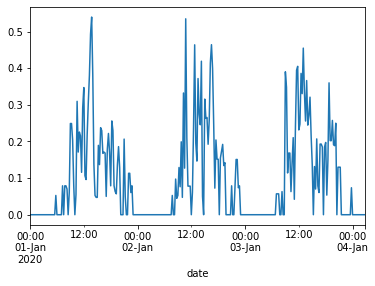

In [25]:
consumption_df.sum(1).iloc[:300].plot()

<AxesSubplot:xlabel='date'>

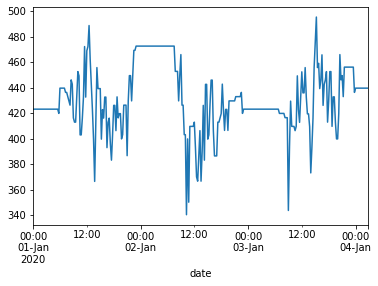

In [26]:
availability_df.sum(1).iloc[:300].plot()

In [27]:
car_properties_df

,BEV6_W2_ab8e6_Tesla_Model_3_Long_Range_AWD_2019,BEV4_W2_c07cc_Renault_Zoe_Q90_2017,BEV2_W2_cbb91_Tesla_Model_3_Long_Range_AWD_2019,BEV6_W2_3866e_Tesla_Model_3_Long_Range_AWD_2019,BEV0_W2_cc753_Tesla_Model_3_Long_Range_AWD_2019,BEV8_W2_76315_Volkswagen_ID.3_2020,BEV1_W2_4b671_Renault_Zoe_Q90_2017,BEV8_W2_bca1b_Tesla_Model_3_Long_Range_AWD_2019,BEV9_W2_888a8_Tesla_Model_3_Long_Range_AWD_2019,BEV3_W2_65f4a_Volkswagen_ID.3_2020,...,BEV2_W2_85ea3_Volkswagen_ID.3_2020,BEV9_W2_d515f_BMW_i3_33_kWh_2017,BEV1_W2_ef0ef_Tesla_Model_3_Long_Range_AWD_2019,BEV5_W2_6e361_Renault_Zoe_Q90_2017,BEV7_W2_b43f0_Volkswagen_ID.3_2020,BEV3_W2_ca7d9_Hyundai_IONIQ_Electric_28_kWh_2019,BEV8_W2_4368d_FIAT_500e_2019,BEV0_W2_933fd_Tesla_Model_3_Long_Range_AWD_2019,BEV4_W2_8c161_Renault_Zoe_Q90_2017,BEV6_W2_1cc03_Tesla_Model_3_Long_Range_AWD_2019
soc_end,1.0,1.00,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.00,1.0
soc_init,0.5,0.50,0.5,0.5,0.5,0.5,0.50,0.5,0.5,0.5,...,0.5,0.5,0.5,0.50,0.5,0.5,0.5,0.5,0.50,0.5
battery_capacity,79.5,45.61,79.5,79.5,79.5,45.0,45.61,79.5,79.5,45.0,...,45.0,33.2,79.5,45.61,45.0,28.0,24.0,79.5,45.61,79.5


In [29]:
consumption_pickle = os.path.join(data_path, "consumption")
availaibilty_pickle = os.path.join(data_path, "availability")
property_pickle = os.path.join(data_path, "properties")

#consumption_df.to_pickle(consumption_pickle)
#availability_df.to_pickle(availaibilty_pickle)
#car_properties_df.to_pickle(property_pickle)


# N-sufficient

In [96]:
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

In [105]:
consumption = pd.read_pickle(os.path.join(data_path, "consumption"))

In [110]:
reduced = consumption.dropna()
n_max = reduced.shape[1]

In [111]:
rmse = {}

for sample_size in range(10, n_max): 
    Y_true = reduced.mean(1)
    Y_pred = reduced.iloc[:,:sample_size].mean(1)
    rmse[f'{sample_size}'] = mean_squared_error(Y_true,Y_pred, squared=False) 

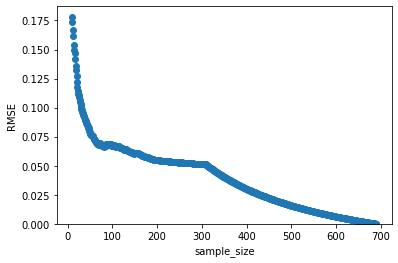

In [112]:
plt.scatter(range(10, n_max), rmse.values())
plt.xlabel("sample_size")
plt.ylabel("RMSE")
plt.ylim(0)
plt.show()

# Plot

In [3]:
data_path = '/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage/Modelling/Git_hub/EES/Emobpy/my_emobpy'

In [4]:
os.makedirs(os.path.join(data_path, "ged"), exist_ok=True)
ged_path = os.path.join(data_path, "ged")

In [14]:
folder_cons = get_folders(used_consumption)
folder_ava = get_folders(availability_path)

NameError: name 'used_consumption' is not defined

In [75]:
strategy = "immediate"
count=0

for folder_nr in folder_ava:
    ts_path = os.path.join(availability_path, str(folder_nr))
    DB = DataBase(ts_path)
    DB.update()
    DB.loadfiles()
    for a_name in os.listdir(ts_path):
        if "DS_Store" not in a_name.split(".pickle")[0]:
            a_name = a_name.split(".pickle")[0]
            print(a_name)
            ged = Charging(a_name)
            ged.load_scenario(DB)
            ged.set_sub_scenario(strategy)
            ged.run()
            ged.save_profile(ged_path)

BEV8_W2_76315_Volkswagen_ID.3_2020_5f056_avai_4f6ea
Profile done: BEV8_W2_76315_Volkswagen_ID.3_2020_5f056_avai_4f6ea_immediate_9bfe8
Was successfully created?:True
BEV7_W2_951b6_Volkswagen_ID.3_2020_63e4a_avai_7d3a9
Profile done: BEV7_W2_951b6_Volkswagen_ID.3_2020_63e4a_avai_7d3a9_immediate_a6737
Was successfully created?:True
BEV3_W2_65f4a_Volkswagen_ID.3_2020_081cd_avai_9d821
Profile done: BEV3_W2_65f4a_Volkswagen_ID.3_2020_081cd_avai_9d821_immediate_f8506
Was successfully created?:True
BEV6_W2_3866e_Tesla_Model_3_Long_Range_AWD_2019_adbbd_avai_0b74d
Profile done: BEV6_W2_3866e_Tesla_Model_3_Long_Range_AWD_2019_adbbd_avai_0b74d_immediate_158c1
Was successfully created?:True
BEV1_W2_4b671_Renault_Zoe_Q90_2017_2085a_avai_0c26c
Balance: -0.01. Consumption: 4.21. charge_battery: 27.01. sto_init: 22.8. sto_end: 45.61
Profile done: BEV1_W2_4b671_Renault_Zoe_Q90_2017_2085a_avai_0c26c_immediate_57bed
Was successfully created?:True
BEV9_W2_888a8_Tesla_Model_3_Long_Range_AWD_2019_6d95d_avai_0

Profile done: BEV7_W2_951b6_Volkswagen_ID.3_2020_63e4a_avai_72772_immediate_35682
Was successfully created?:True
BEV5_W2_8015b_Renault_Zoe_Q90_2017_ea5b7_avai_8cce1
Profile done: BEV5_W2_8015b_Renault_Zoe_Q90_2017_ea5b7_avai_8cce1_immediate_4521b
Was successfully created?:True
BEV4_W2_8631d_Tesla_Model_3_Long_Range_AWD_2019_e0d3b_avai_d8956
Balance: 0.01. Consumption: 5.18. charge_battery: 44.83. sto_init: 39.75. sto_end: 79.39
Profile done: BEV4_W2_8631d_Tesla_Model_3_Long_Range_AWD_2019_e0d3b_avai_d8956_immediate_9fcd2
Was successfully created?:True
BEV6_W2_3866e_Tesla_Model_3_Long_Range_AWD_2019_adbbd_avai_a99f0
Profile done: BEV6_W2_3866e_Tesla_Model_3_Long_Range_AWD_2019_adbbd_avai_a99f0_immediate_b4e46
Was successfully created?:True
BEV6_W2_27d26_Tesla_Model_3_Long_Range_AWD_2019_b91ac_avai_8b6ac
Profile done: BEV6_W2_27d26_Tesla_Model_3_Long_Range_AWD_2019_b91ac_avai_8b6ac_immediate_80ff8
Was successfully created?:True
BEV8_W2_1b304_Renault_Zoe_Q90_2017_5a9fe_avai_bf4c9
Balance:

['BEV36_W53_3666d_Tesla_Model_3_Long_Range_AWD_2019_9090f_avai_3c13c_immediate_2684e.pickle',
 'BEV527_W53_47c94_Tesla_Model_3_Long_Range_AWD_2019_eb18f_avai_cdd02_immediate_4643e.pickle',
 'BEV296_W53_7e81a_Audi_e-tron_55_quattro_2019_8b211_avai_6b825_immediate_7e744.pickle',
 'BEV185_W53_e162a_Volkswagen_ID.3_2020_3f590_avai_0858d_immediate_7026f.pickle',
 'BEV46_W53_8d9d0_Volkswagen_ID.3_2020_7a9e5_avai_72c41_immediate_12bff.pickle',
 'BEV48_W53_8bfa5_Volkswagen_ID.3_2020_cc3b2_avai_f6154_immediate_aabfa.pickle',
 'BEV576_W53_f6d55_Tesla_Model_3_Long_Range_AWD_2019_4f553_avai_f5a80_immediate_f8631.pickle',
 'BEV485_W53_cf21d_Volkswagen_ID.3_2020_37ddb_avai_ae507_immediate_55372.pickle',
 'BEV172_W53_64117_Tesla_Model_3_Long_Range_AWD_2019_618f6_avai_7b3d1_immediate_184a3.pickle',
 'BEV139_W53_42d7e_Tesla_Model_3_Long_Range_AWD_2019_6c12c_avai_3ad31_immediate_6a3ba.pickle',
 'BEV213_W53_72292_Tesla_Model_3_Long_Range_AWD_2019_dc1b0_avai_af4a0_immediate_93e39.pickle',
 'BEV123_W53_bc0

In [10]:
import pickle5 as pickle

ModuleNotFoundError: No module named 'pickle5'

In [9]:
pd.read_pickle(os.path.join(ged_path, os.listdir(ged_path)[0]))

with open(os.path.join(ged_path, os.listdir(ged_path)[0]), "rb") as fh:
    consumption_ts = pickle.load(fh)



UnpicklingError: invalid load key, '\x1f'.

In [16]:
for grid_demand in os.listdir(ged_path):
    df 

'/Users/Jarusch/Documents/Hertie/Hertie School/OneDrive - Hertie School/Jarusch/Virtual_storage/Modelling/Git_hub/EES/Emobpy/my_emobpy/ged'

In [17]:
GDB = DataBase(ged_path)
GDB.loadfiles()

data = []
for grid_demand in GDB.db:
    df = GDB.db[grid_demand]['timeseries']
    df['id'] = grid_demand
    data.append(df[['id','hh','state','charging_point','charge_grid']]) # must include 'id','hh','state' remaining are optional and depend on the time series type

df = pd.concat(data)
df.iloc[:,0].unique().size

AttributeError: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/Users/Jarusch/opt/anaconda3/envs/emobpyenv/lib/python3.7/site-packages/pandas/_libs/internals.cpython-37m-darwin.so'>

In [9]:
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()

In [10]:
def start_and_end_week(df, column_values='charge_grid'):
    '''Remove first and last week as days are missing causing inconsistent average'''
    dt = df.reset_index()
    dt['half'] = dt['date'] - min(dt['date'])
    dt = dt.set_index('date')
    dt = data_curation(dt,column_values=column_values).T
    sr = dt['charge_grid']
    start = len(sr[sr.columns[0]].dropna())
    ends = len(sr[sr.columns[-1]].dropna())
    dt = df.reset_index()
    dt['half'] = dt['date'] - min(dt['date'])
    #dt = dt[(dt['half'] <= pd.to_timedelta(start,'H')) & (dt['half'] >= pd.to_timedelta(dt['hh'].max() - ends,'H'))].copy()
    df = dt.set_index('date')
    return df

In [11]:
def data_curation(df, column_values='charge_grid'):
    ''' 
    Convert data frame with all profiles to days of the week and hours of the day
    id represents every profile
    step1 sum up all profiles
    step2 makes the average
    '''
    profiles_n = len(set(df['id'].values))
    step1 = df.groupby([df.index.day_name(),df.index.hour,df.index.isocalendar().week])[column_values].sum()
    step2 = step1/profiles_n
    step3 = pd.DataFrame(step2)
    step4 = step3.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],level=0)
    return step4.unstack().T 

def start_and_end_week_full(df, column_values='charge_grid'):
    '''Remove first and last week as days are missing causing inconsistent average'''
    dt = df.reset_index()
    dt['half'] = dt['date'] - min(dt['date'])
    dt = dt.set_index('date')
    dt = data_curation(dt,column_values=column_values).T
    sr = dt['charge_grid']
    start = len(sr[sr.columns[0]].dropna())
    ends = len(sr[sr.columns[-1]].dropna())
    dt = df.reset_index()
    dt['half'] = dt['date'] - min(dt['date'])
    dt = dt[(dt['half'] <= pd.to_timedelta(start,'H')) & (dt['half'] >= pd.to_timedelta(dt['hh'].max() - ends,'H'))].copy()
    df = dt.set_index('date')
    return df

def shares_plot(df, column_values='state', order=['driving','workplace','errands','escort','shopping','leisure','home']):
    '''
    Plot of category shares either locations ('states') or charging point names ('charging_point')
    '''
    sr_count = df.groupby([df.index.day_name(),df.index.hour,column_values])[column_values].count()
    df_count = pd.DataFrame(sr_count).rename(columns={column_values:'count'}).unstack(level=-1).fillna(0)
    df_count.columns = df_count.columns.droplevel()
    present = [exists for exists in order if exists in df_count.columns]
    df_count_sorted = df_count[present[::-1]].reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],level=0)
    df_new_index = (df_count_sorted.T/df_count_sorted.T.sum(axis=0)).T
    df_new_index.loc[:,'new_index'] = [[str(h)+ ',' + d[:3]] for d,h in df_new_index.index.values]
    #[[str(h) if h > 9 else '0'+str(h)][0] ]+ ',' + d[:3] for d,h in df_new_index.index.values]
    df_new_index.set_index('new_index',inplace=True)
    fig = df_new_index.iplot(kind='area', fill=True,asFigure=True)
    fig['layout'] = {}
    return fig

def box_plot(df, name, column_values='charge_grid', factor=1, color='#14868c',legendname_position=2):
  '''
  Box plot of distance, consumption, or charge_grid. 
  column_values must exist in the df
  '''
  dt = data_curation(df,column_values=column_values)
  data = []
  # Every boxplot has given name. The legend takes the name, legendgroup allows all boxplot with the same identifier have the same color
  flag = legendname_position  # as we the first boxplot is used as xaxis tick we move the name to the next position
  flagcompare = 0
  for key, v in dt.iteritems():
      flagcompare += 1
      data.append({'boxpoints': False, # 'suspectedoutliers' or False
                        'line': {'width': 1.2},
                      'marker': {'color': color},
                        'name': f'''{str(key[1]).zfill(2)},{key[0][0:3]}''' if flag != flagcompare else name,
                  'orientation': 'v',
                        'type': 'box',
                            'y': v.values*factor,
                        'xaxis': 'x',
                      'jitter': 0.0,
                'whiskerwidth': 1.0,
                      'notched': False,
                  'notchwidth': 0.2,
                  'showlegend': False if flag != flagcompare else True,
                  'legendgroup': name
                  })
  return go.Figure(data)

In [17]:
dt = start_and_end_week(df)
figa = shares_plot(dt, column_values='charging_point', order=['none', 'public', 'fast150', 'fast75'])
figb = box_plot(dt, 'Average vehicle [kWh]', column_values='charge_grid', factor=1, color='#14868c',legendname_position=2)
fig = cf.subplots([shares_plot(dt),figb],shape=(2,1),shared_xaxes=False)

In [28]:
df_count = pd.DataFrame(sr_count).rename(columns={column_values:'count'}).unstack(level=-1).fillna(0)

In [31]:
df_count_sorted = df_count[present[::-1]].reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],level=0)
df_new_index = (df_count_sorted.T/df_count_sorted.T.sum(axis=0)).T
df_new_index.loc[:,'new_index'] = [[str(h)+ ',' + d[:3]] for d,h in df_new_index.index.values]
#[[str(h) if h > 9 else '0'+str(h)][0] ]+ ',' + d[:3] for d,h in df_new_index.index.values]
df_new_index.set_index('new_index',inplace=True)
#fig = df_new_index.iplot(kind='area', fill=True,asFigure=True)
#fig['layout'] = {}

In [35]:
df_new_index.iplot(kind='area', fill=True,asFigure=True)

Layout({
    'legend': {'bgcolor': '#F5F6F9', 'font': {'color': '#4D5663'}},
    'paper_bgcolor': '#F5F6F9',
    'plot_bgcolor': '#F5F6F9',
    'template': '...',
    'title': {'font': {'color': '#4D5663'}},
    'xaxis': {'gridcolor': '#E1E5ED',
              'showgrid': True,
              'tickfont': {'color': '#4D5663'},
              'title': {'font': {'color': '#4D5663'}, 'text': ''},
              'zerolinecolor': '#E1E5ED'},
    'yaxis': {'gridcolor': '#E1E5ED',
              'showgrid': True,
              'tickfont': {'color': '#4D5663'},
              'title': {'font': {'color': '#4D5663'}, 'text': ''},
              'zerolinecolor': '#E1E5ED'}
})

<AxesSubplot:xlabel='new_index'>

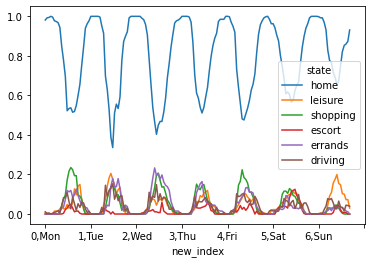

In [39]:
df_new_index#.plot(kind='area')

In [19]:
shares_plot(dt) # with state as default

In [95]:
# Final customization

fig['layout']['xaxis'].update({'showticklabels':True})
xaxisdct = {'automargin': False,
              'showgrid': False,
              'showline': True,
#               'zeroline':True,
              'tickmode':'array',
              'tickvals': ['00,Mon', '06,Mon', '12,Mon', '18,Mon',
                           '00,Tue', '06,Tue', '12,Tue', '18,Tue',
                           '00,Wed', '06,Wed', '12,Wed', '18,Wed',
                           '00,Thu', '06,Thu', '12,Thu', '18,Thu',
                           '00,Fri', '06,Fri', '12,Fri', '18,Fri',
                           '00,Sat', '06,Sat', '12,Sat', '18,Sat',
                           '00,Sun', '06,Sun', '12,Sun', '18,Sun','23,Sun'],
              'ticktext': ['00:00<br>', '06:00<br>', '12:00<br>Monday', '18:00<br>',
                           '00:00<br>', '06:00<br>', '12:00<br>Tuesday', '18:00<br>',
                           '00:00<br>', '06:00<br>', '12:00<br>Wednesday', '18:00<br>',
                           '00:00<br>', '06:00<br>', '12:00<br>Thursday', '18:00<br>',
                           '00:00<br>', '06:00<br>', '12:00<br>Friday', '18:00<br>',
                           '00:00<br>', '06:00<br>', '12:00<br>Saturday', '18:00<br>',
                           '00:00<br>', '06:00<br>', '12:00<br>Sunday', '18:00<br>','23:00<br>'],
               'ticklen': 2,
             'tickwidth': 2,
              'tickfont':{'family': 'Arial, sans-serif',
                            'size': 7,
                           'color': 'black'},
             'linewidth': 2,
#          'zerolinecolor': '#969696',
#          'zerolinewidth': 2,
        'showticklabels':True,
                "ticks":"outside",
                'ticklen': 2,
                'tickwidth': 2,
            'linecolor': 'black',
           }
fig['layout']['xaxis'].update(xaxisdct)
# fig['layout']['xaxis'].update({'showticklabels':False})
fig['layout']['xaxis2'].update(xaxisdct)

fig['layout']['yaxis'].update({'title': 'Share',
                           'titlefont': {'size':12},
                            'showgrid': False,'showline':True,'rangemode':"tozero", 'zeroline' : True,
                              'domain': [0.6, 1.0],'tickformat' : ',.0%',
                            'tickfont': {'family': 'Arial, sans-serif',
                                           'size': 12,
                                          'color': 'black'},
                           'linewidth':2,
                            "ticks":"outside",
                            'ticklen': 2,
                            'tickwidth': 2,
                               'linecolor': 'black',
                              })
fig['layout']['yaxis2'].update({'title': 'Grid electricity demand (kWh)',
                            'titlefont': {'size':12},
                             'showgrid': True,'showline':True,'rangemode':"tozero",
                               'domain': [0.0, 0.5],
                             'tickfont': {'family': 'Arial, sans-serif',
                                            'size': 12,
                                           'color': 'black'},
                            'linewidth':2,
                                'range': [0,35],
                                'dtick': 5,
                            "ticks":"outside",
                            'ticklen': 2,
                            'tickwidth': 2,
                            'linecolor': 'black',
                               })

fig['layout'].update({'paper_bgcolor': 'white',
                       'plot_bgcolor': 'white',
                             'margin': dict(l=70, r=15, t=20, b=50, pad=0),
                              'width': 1000,
                             'height': 700,
                         'showlegend': True,
                             'legend': {'orientation': 'h','x': 0.15, 'y': 1.04,
                                        'font': dict(family= 'Arial, sans-serif',
                                                       size= 12,
                                                      color= 'black')}
                     })

iplot(fig,show_link=False)

In [72]:
from emobpy.plot import NBplot

DB = DataBase(os.path.join(used_profile, "0"))
DB.update()
DB.loadfiles()
PLT = NBplot(DB)

m = DB.db[
    list(DB.db.keys())[0]
]

In [62]:
fig_availability = PLT.sgplot_ga(ga["name"], rng=None, to_html=False, path=None)
fig_availability

In [66]:
fig_consumption = PLT.sankey(c["name"], include=None, to_html=False, path=None)
fig_consumption

Consumption [kWh]: 3.951
Distance [km]: 537.0
Specific consumption [kWh/100 km]: 0.736


In [71]:
fig_mobility = NBplot(DB).sgplot_dp(m["name"])
fig_mobility